In [1]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"

2.4.0+cu121
12.1


In [2]:
# version should match with torch and cuda
%%bash
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 59.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 54.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.2/986.2 kB 36.6 MB/s eta 0:00:00


In [3]:
!pip install torch_geometric==2.2.0
!pip install torch_geometric_temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773275 sha256=dbf7a1321e0e8640f57c232b902e68699712f5c94147de58782cbb1797fb3757
  Stored in directory: /root/.cache/pip/wheels/c8/e4/83/5e964867e23f8a61cb8c5d5b9477617b710e96e6ebf1844562
Successfully built torch_geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 116.3 MB/s eta 0:00:00
  Created wheel for torch_geometric_temporal: filename=torch_geometric_temporal-0.54.0-py3-none-any.whl size=86712 sha256=cdcbcebfd975341dbb76bb36339241baee2aff57fd1f5cbd63f2f235afad0fb4
  Stored in directory: /root/.cache/pip/wheels/9e/9b/b6/e15256e053f0cb49b1084a67a709db909d418386a231f0722c
Successfully built torch_geometric_temporal
  Attempting uninstall: pa

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import copy

from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim

from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.nn.attention import ASTGCN   # For information about the architecture check the source code

# GPU support
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shuffle=True
batch_size = 8

In [6]:
# 從文件加載數據集的組件
data = torch.load('/content/drive/MyDrive/Dissertation/DissertationData/static_graph_temporal_signal.pt')

edge_index = data['edge_index']
edge_attr = data['edge_attr']
features_list = data['features']
targets_list = data['targets']

# 建 StaticGraphTemporalSignal 數據集
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_attr,
    features=features_list,
    targets=targets_list
)

# 打印數據集類型
print("Dataset type: ", type(dataset))

# 計算樣本數量（序列數量）
num_samples = sum(1 for _ in dataset)
print("Number of samples / sequences: ", num_samples)

# 顯示第一個樣本的內容
first_sample = next(iter(dataset))
print("First sample:", first_sample)

<ipython-input-6-27d31b0910a9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/content/drive/MyDrive/Dissertation/DissertationData/static_graph_temporal

Dataset type:  <class 'torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal'>
Number of samples / sequences:  1940
First sample: Data(x=[5650, 1, 1], edge_index=[2, 47624], edge_attr=[47624], y=[5650, 1])


x=[5650, 1, 1]:

x 是特徵張量，形狀為 [num_nodes, num_features, timesteps]。這裡 num_nodes 是 5650，num_features 是 1，timesteps 是 1。這表示每個節點有一個特徵，且時間步長為 1（這與你的設置不完全一致，可能需要檢查設定）。
edge_index=[2, 47624]:

edge_index 是邊的索引，形狀為 [2, num_edges]，這裡 num_edges 是 47624，表示圖中的邊。
edge_attr=[47624]:

edge_attr 是邊的權重或相似度，形狀為 [num_edges]，這裡 num_edges 是 47624，與 edge_index 的邊數量一致。
y=[5650, 1]:

y 是目標張量，形狀為 [num_nodes, timesteps]，這裡 num_nodes 是 5650，timesteps 是 1。這表示每個節點在這個時間步長上的標籤值。

In [7]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

train_count = sum(1 for _ in train_dataset)
test_count = sum(1 for _ in test_dataset)

print("Number of train buckets: ", train_count)
print("Number of test buckets: ", test_count)

Number of train buckets:  1552
Number of test buckets:  388


# ***Creating DataLoaders***

In [8]:
# 準備訓練集和測試集的數據
train_input = np.array(train_dataset.features)  # (num_samples, num_nodes, num_features, num_timesteps)
train_target = np.array(train_dataset.targets)  # (num_samples, num_nodes, num_timesteps)
test_input = np.array(test_dataset.features)    # (num_samples, num_nodes, num_features, num_timesteps)
test_target = np.array(test_dataset.targets)    # (num_samples, num_nodes, num_timesteps)

# 將數據轉換為Tensor
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)

# 將訓練數據打包為TensorDataset
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)

In [9]:
validation_split = 0.2  # 設定驗證集比例

# 計算訓練集和驗證集的大小
val_size = int(len(train_dataset_new) * validation_split)
train_size = len(train_dataset_new) - val_size

# 隨機劃分訓練集和驗證集
train_dataset_final, val_dataset = torch.utils.data.random_split(train_dataset_new, [train_size, val_size])

# 創建 DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset_final, batch_size=batch_size, shuffle=shuffle, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

# 同樣為測試集創建 DataLoader
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle, drop_last=True)

# 打印劃分後的數據集大小
print(f"Training Set: {len(train_loader.dataset)}")
print(f"Validation Set: {len(val_loader.dataset)}")
print(f"Testing Set: {len(test_loader.dataset)}")

Training Set: 1242
Validation Set: 310
Testing Set: 388


# ***Model***

In [10]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = 1  # 我的時間步數
num_for_predict = 1  # 我的時間步數
len_input = 1  # 我的時間步數
num_of_vertices = 5650  # 節點數

# Initialize ASTGCN model
model = ASTGCN(nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

#print(model)  # Print the model architecture

In [17]:
# 自訂 RMSSE 損失函數
class RMSSELoss(nn.Module):
    def __init__(self):
        super(RMSSELoss, self).__init__()

    def forward(self, y_pred, y_true, y_train):
        # y_pred: Predicted values
        # y_true: Actual values
        # y_train: Historical training data to calculate scale

        # Calculate the numerator (mean squared error)
        numerator = torch.mean((y_pred - y_true) ** 2)

        # Calculate the denominator (mean squared scale)
        scale = torch.mean((y_train[1:] - y_train[:-1]) ** 2)

        # Compute RMSSE
        rmsse = torch.sqrt(numerator / scale)

        return rmsse
# model_path = "/content/drive/MyDrive/Dissertation/DissertationData/BestModel0826/bm-gcn-flow0826.params"  # 儲存最佳模型的路徑


In [19]:
# 定義驗證損失計算函數
def compute_val_loss_mstgcn(model, val_loader, criterion, masked_flag, missing_value, epoch, edge_index):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_data in val_loader:
            encoder_inputs, labels = batch_data
            encoder_inputs = encoder_inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            edge_index = edge_index.to(DEVICE)

            y_hat = model(encoder_inputs, edge_index)

            if masked_flag:
                mask = (labels != missing_value).float()
                loss = (criterion(y_hat, labels, encoder_inputs) * mask).mean()
            else:
                loss = criterion(y_hat, labels, encoder_inputs)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss

In [23]:
# 訓練函數
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, edge_index, epochs=20, early_stop=5):
    min_vali_loss = float('inf')
    wait = 0
    best_epoch = 0
    best_state_dict = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"Starting training for epoch {epoch + 1}...")
        model.train()
        step = 0
        loss_list = []

        for batch_data in train_loader:
            encoder_inputs, labels = batch_data
            encoder_inputs = encoder_inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            edge_index = edge_index.to(DEVICE)
            optimizer.zero_grad()

            # Forward pass
            y_hat = model(encoder_inputs, edge_index)

            # Compute loss using RMSSELoss
            loss = criterion(y_hat, labels, encoder_inputs)
            loss.backward()
            optimizer.step()

            step += 1
            loss_list.append(loss.item())  # 直接收集 RMSSE loss

            if step % 30 == 0:
                print(f"Epoch {epoch + 1}, Step {step}, Performing validation...")
                vali_loss = compute_val_loss_mstgcn(model, val_loader, criterion, masked_flag, missing_value, epoch, edge_index)
                print(f"Epoch {epoch + 1}, Step {step}, Validation Loss (RMSSE): {vali_loss:.4f}")

                if vali_loss < min_vali_loss:
                    wait = 0
                    min_vali_loss = vali_loss
                    best_epoch = epoch
                    best_state_dict = copy.deepcopy(model.state_dict())
                    print(f"Best epoch so far is {best_epoch + 1}, Validation Loss: {min_vali_loss:.4f}. Model saved.")
                else:
                    wait += 1
                    if wait >= early_stop:
                        print(f"Early stopping at epoch {epoch + 1}.")
                        model.load_state_dict(best_state_dict)
                        break

                model.train()

        # 計算該 epoch 的平均 RMSSE
        avg_train_rmsse = np.mean(loss_list)  # 這裡的 loss_list 已經是 RMSSE loss
        train_losses.append(avg_train_rmsse)
        val_losses.append(vali_loss)

        print(f"Epoch {epoch + 1} Training RMSSE: {avg_train_rmsse:.4f}")
        print(f"Epoch {epoch + 1} Validation Loss (RMSSE): {vali_loss:.4f}")

    # 保存最佳模型
    if best_state_dict is not None:
        model_path = "/content/drive/MyDrive/Dissertation/DissertationData/BestModel0826/bm-gcn-flow0826.params"
        torch.save(best_state_dict, model_path)
        print(f"Model saved to {model_path}")

    return train_losses, val_losses, min_vali_loss

In [20]:
# 初始化模型和優化器
learning_rate = 0.001
model = ASTGCN(nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)
criterion = RMSSELoss().to(DEVICE)  # 使用自定義的 RMSSE 作為損失函數
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
train_losses, val_losses, min_val_loss = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, edge_index, epochs=20, early_stop=5)

Starting training for epoch 1...
Epoch 1, Step 30, Performing validation...
Epoch 1, Step 30, Validation Loss (RMSSE): 0.1424
Best epoch so far is 1, Validation Loss: 0.1424. Model saved.
Epoch 1, Step 60, Performing validation...
Epoch 1, Step 60, Validation Loss (RMSSE): 0.1421
Best epoch so far is 1, Validation Loss: 0.1421. Model saved.
Epoch 1, Step 90, Performing validation...
Epoch 1, Step 90, Validation Loss (RMSSE): 0.1407
Best epoch so far is 1, Validation Loss: 0.1407. Model saved.
Epoch 1, Step 120, Performing validation...
Epoch 1, Step 120, Validation Loss (RMSSE): 0.1401
Best epoch so far is 1, Validation Loss: 0.1401. Model saved.
Epoch 1, Step 150, Performing validation...
Epoch 1, Step 150, Validation Loss (RMSSE): 0.1413
Epoch 1 Training RMSSE: 0.6830
Epoch 1 Validation Loss (RMSSE): 0.1413
Starting training for epoch 2...
Epoch 2, Step 30, Performing validation...
Epoch 2, Step 30, Validation Loss (RMSSE): 0.1416
Epoch 2, Step 60, Performing validation...
Epoch 2, S

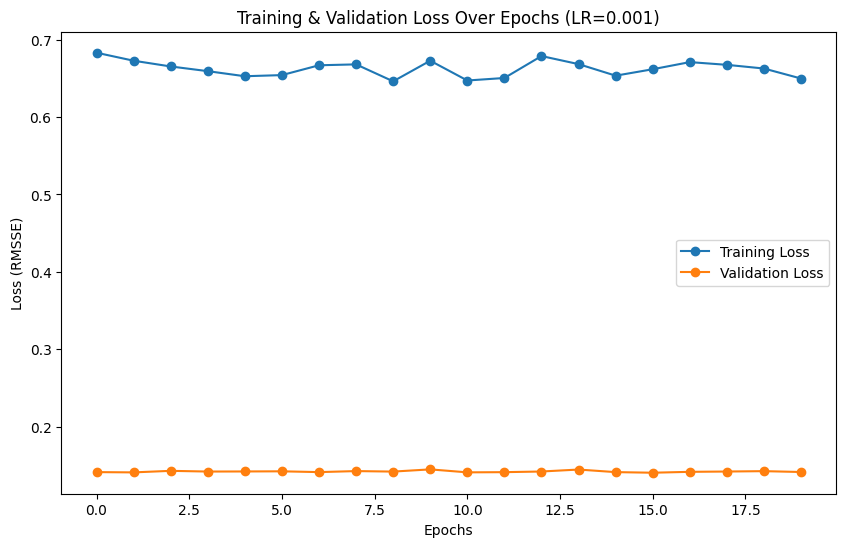

In [25]:
# 繪製訓練和驗證損失圖表
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training & Validation Loss Over Epochs (LR=0.001)')
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSSE)')
plt.legend()
plt.show()

# ***Evaluate***

In [42]:
def calculate_rmse(y_true, y_pred):
    """
    計算 RMSE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)

    返回:
    - rmse: 計算出的 RMSE 值
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_rmsse(y_true, y_pred, y_train, epsilon=1e-10):
    """
    計算 RMSSE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)
    - y_train: 訓練集的真實值 (numpy array)
    - epsilon: 防止除零的小正數，默認為1e-10

    返回:
    - rmsse: 計算出的 RMSSE 值
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_train = np.asarray(y_train)

    # 計算均方誤差（MSE）
    mse = np.mean((y_true - y_pred) ** 2)

    # 計算差分的均方差（用於 RMSSE 計算的分母）
    diff = np.diff(y_train, axis=0) ** 2
    denominator = np.mean(diff)

    # 避免分母為零
    if denominator == 0:
        denominator = epsilon

    rmsse = np.sqrt(mse / denominator)
    return rmsse

def calculate_mape(y_true, y_pred):
    """
    計算 MAPE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)

    返回:
    - mape: 計算出的 MAPE 值，以百分比表示
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # 忽略 y_true 為零的情況
    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [43]:
def calculate_wrmsse(y_true, y_pred, y_train, weights=None, epsilon=1e-10):
    """
    計算 WRMSSE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)
    - y_train: 訓練集的真實值 (numpy array)
    - weights: 每個時間序列的權重 (numpy array)，默認為 None
    - epsilon: 防止除零的小正數

    返回:
    - wrmsse: 计算出的 WRMSSE 值
    """
    # 確保輸入是 numpy 陣列
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_train = np.asarray(y_train)

    # 計算每個時間序列的均方誤差（MSE）
    mse = np.mean((y_true - y_pred) ** 2, axis=0)

    # 計算差分的均方差（用於 RMSSE 計算的分母）
    diff = np.diff(y_train, axis=0) ** 2
    denominator = np.mean(diff, axis=0)

    # 避免分母為零：將分母為零的地方設置為一個小正數
    denominator = np.where(denominator > epsilon, denominator, epsilon)

    # 計算每個時間序列的 RMSSE
    rmsse = np.sqrt(mse / denominator)

    # 計算加權 RMSSE
    if weights is not None:
        weights = np.asarray(weights)
        if weights.shape[0] != rmsse.shape[0]:
            raise ValueError("Weights length must match the number of series.")
        wrmsse = np.sum(weights * rmsse)
    else:
        wrmsse = np.mean(rmsse)

    return wrmsse

In [44]:
# 使用訓練集計算 RMSSE 和 WRMSSE
y_train_np = train_target_tensor.cpu().numpy()

# 計算基於總和的權重
weights = np.sum(y_train_np, axis=0) / np.sum(y_train_np)

In [45]:
# 切換模型到評估模式
model.eval()
test_loss = 0

all_outputs = []  # 用於保存所有批次的預測結果
all_labels = []  # 用於保存所有批次的真實標籤

with torch.no_grad():  # 在測試過程中禁用梯度計算
    for batch_data in test_loader:
        encoder_inputs, labels = batch_data
        encoder_inputs = encoder_inputs.to(DEVICE)  # 將數據移動到 GPU
        labels = labels.to(DEVICE)
        edge_index = edge_index.to(DEVICE)

        # 模型推斷
        y_hat = model(encoder_inputs, edge_index)

        # 計算損失
        if masked_flag:
            mask = (labels != missing_value).float()
            loss = (criterion(y_hat, labels, encoder_inputs) * mask).mean()
        else:
            loss = criterion(y_hat, labels, encoder_inputs)

        test_loss += loss.item()

        # 保存當前批次的預測結果和真實標籤
        all_outputs.append(y_hat.cpu().numpy())  # 轉換到 numpy array
        all_labels.append(labels.cpu().numpy())  # 轉換到 numpy array

# 計算平均測試損失
test_loss /= len(test_loader)
print(f"Testing loss: {test_loss:.4f}")

Testing loss: 0.2216


In [46]:
# 將所有批次的預測結果和真實標籤合併為單個數組
y_test_pred = np.concatenate(all_outputs, axis=0)
y_test_true = np.concatenate(all_labels, axis=0)

# 計算 RMSE
rmse = calculate_rmse(y_test_true, y_test_pred)
print(f'Test RMSE: {rmse:.4f}')

# 計算 RMSSE
rmsse = calculate_rmsse(y_test_true, y_test_pred, y_train_np)
print(f'Test RMSSE: {rmsse:.4f}')

# 計算 MAPE
mape = calculate_mape(y_test_true, y_test_pred)
print(f'Test MAPE: {mape:.2f}%')

# 計算 WRMSSE，使用正確的權重
wrmsse = calculate_wrmsse(y_test_true, y_test_pred, y_train_np, weights=weights)
print(f'Test WRMSSE: {wrmsse:.4f}')

Test RMSE: 1.8623
Test RMSSE: 0.8325
Test MAPE: 70.63%
Test WRMSSE: 0.7919


1. **Test RMSE (1.8623)**:
   - 這個值表示預測值和真實值之間的均方根誤差。它是一個絕對指標，沒有考慮每個時間序列的變異性。
   - **RMSE** 在 1.8623 這個範圍內，表示模型在測試數據上的平均預測誤差大約是 1.86 個單位。

2. **Test RMSSE (0.8325)**:
   - **RMSSE** 是對 RMSE 的標準化，使其能夠更好地比較不同序列或不同模型的預測誤差。值越接近 0，表示預測誤差越小。
   - RMSSE 的值為 0.8325 表明模型的預測誤差相對於序列自身的變化範圍是相對較小的。

3. **Test MAPE (70.63%)**:
   - **MAPE** (Mean Absolute Percentage Error) 表示預測值與真實值之間的平均百分比誤差。
   - 70.63% 的 MAPE 表明預測與實際值之間的偏差相對較高。這可能意味著模型在某些數據點的預測不準確，特別是當真實值非常小的時候，MAPE 會變得非常敏感。

4. **Test WRMSSE (0.7919)**:
   - **WRMSSE** 是加權的 RMSSE，考慮了每個時間序列的重要性。這個值的降低表明模型現在更均勻地處理了不同時間序列的誤差，並且權重設置得當。
   - WRMSSE 值為 0.7919 表明，考慮了各時間序列的權重後，模型的整體預測誤差進一步減小。